In [1]:
import pandas as pd
import numpy as np
import random
import csv
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from time import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math
import random
from imblearn.over_sampling import SMOTE

In [17]:
url = "D:\\TUGAS AKHIR\\Data TA\\bkbk.csv"
data = pd.read_csv(url, header = 0)
data = data.sample(n=5000, random_state = 42)
fraud_flag = data["fraud_flag"]
data["created_date_trx"] = pd.to_datetime(data["created_date_trx"])
data = data.sort_values(by=['created_date_trx'])

In [18]:
# Get one hot encoding of columns B

data = data.drop(columns = ["trx_no","name_subcategory", "stuff_id", "seller_id","invoice_id"])
one_hot = pd.get_dummies(data["name_category"])
# Drop column B as it is now encoded
data = data.drop("name_category",axis = 1)
# Join the encoded df
data = data.join(one_hot)

In [19]:
data.fraud_flag.value_counts()

0    4831
1     169
Name: fraud_flag, dtype: int64

In [20]:
stats = data.groupby('user_id')['stuff_price'].agg(['mean', 'max', 'min'])
stats.columns = ['user_mean_stuff_price', 'user_max_stuff_price', 'user_min_stuff_price']
data = data.merge(stats, left_on = 'user_id', right_index=True, how = 'left')
data.sort_values(by=['user_id'])

stats = data.groupby('user_id')['DISCOUNT'].agg(['mean', 'sum'])
stats.columns = ['user_mean_DISCOUNT', 'user_sum_DISCOUNT']
data = data.merge(stats, left_on = 'user_id', right_index=True, how = 'left')
data.sort_values(by=['user_id'])

stats = data.groupby('user_id')['quantity'].agg(['sum'])
stats.columns = ['user_total_quantity']
data = data.merge(stats, left_on = 'user_id', right_index=True, how = 'left')



In [21]:
data = data.assign(last_buy = data.groupby('user_id').created_date_trx.apply(lambda x: x - x.iloc[0]))
data = data.sort_values(by=['user_id'])
data['last_buy'] = data['last_buy'].array.seconds
data = data.drop(columns = ["created_date_trx"])

In [23]:
data[['quantity','stuff_price', 'DISCOUNT', 'shipping_cost','user_mean_stuff_price','user_max_stuff_price','user_min_stuff_price','user_mean_DISCOUNT','user_sum_DISCOUNT','user_total_quantity','last_buy']] = StandardScaler().fit_transform(data[['quantity','stuff_price', 'DISCOUNT', 'shipping_cost','user_mean_stuff_price','user_max_stuff_price','user_min_stuff_price','user_mean_DISCOUNT','user_sum_DISCOUNT','user_total_quantity','last_buy']])

In [33]:
X = data.drop(columns = ["user_id", 'fraud_flag'])
y = data['fraud_flag']
sm = SMOTE(random_state=42)
X, y = sm.fit_sample(X,y)

In [34]:
np.bincount(y)

array([4831, 4831], dtype=int64)

In [35]:
K = 0.3
c1 = 2.05
c2 = 2.05
c = c1 + c2
khi = 2*K/(abs(2-c-math.sqrt(c**2-4*c)))
n_iterations = 10
n_particles = 100

def fitness_function(position):
    kf = KFold(n_splits = 3)
    svclassifier = SVC(kernel='rbf', gamma = position[0], C = position[1] )  
   # svclassifier.fit(X_train, y_train)
    scores = cross_val_score(svclassifier, X, y, cv = kf, scoring = 'roc_auc')
    return np.mean(scores)
   # y_train_pred = svclassifier.predict(X_train)
   # y_test_pred = svclassifier.predict(X_test)   
   # return (confusion_matrix(y_train,y_train_pred)[0][1] + confusion_matrix(y_train,y_train_pred)[1][0])/np.sum(confusion_matrix(y_train,y_train_pred)), (confusion_matrix(y_test,y_test_pred)[0][1] + confusion_matrix(y_test,y_test_pred)[1][0])/np.sum(confusion_matrix(y_test,y_test_pred))

#plotting (x axis = gamma, y axis = C)
def plot(position):
    x = []
    y = []
    for i in range(0,len(particle_position_vector)):
        x.append(particle_position_vector[i][0])
        y.append(particle_position_vector[i][1])
    colors = (0,0,0)
    plt.scatter(x, y, c = colors, alpha = 0.3)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.axis([-1,11,-1,11])
    plt.gca().set_aspect('equal', adjustable='box')
    return plt.show()

for i in range(n_particles):
    max_velocity = np.array([10,10])
    min_velocity = np.array([-10,-10])
    max_position = np.array([10,10])
    min_position = np.array([0.0001, 0.001])

def eval_velocity(new_velocity):
    for j in range(0,2):
        if(new_velocity[j] > max_velocity[j]):
            new_velocity[j] = max_velocity[j]
        elif(new_velocity[j] < min_velocity[j]):
            new_velocity[j] = min_velocity[j]
    return new_velocity

def eval_position(particle_position_vector):
    for j in range(0,2):
        if(particle_position_vector[j] > max_position[j]):
            particle_position_vector[j] = max_position[j]
        elif(particle_position_vector[j] < min_position[j]):
            particle_position_vector[j] = min_position[j]
    return particle_position_vector
  
particle_position_vector = np.array([np.array([random.random()*10, random.random()*10]) for _ in range(n_particles)])
pbest_position = particle_position_vector
pbest_fitness_value = np.array([0 for _ in range(n_particles)])
gbest_fitness_value = np.array([0])
gbest_position = np.array([float('inf'), float('inf')])
velocity_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1)))*random.random()*2,(-1) ** (bool(random.getrandbits(1))) * random.random()*2]) for _ in range(n_particles)])
#velocity_vector = ([np.array([0, 0]) for _ in range(n_particles)])
iteration = 0

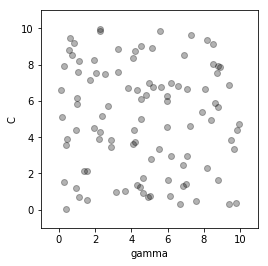

AUC for particle - 1 is 0.5543288543817914  At (gamma, c):  [9.37292638 6.87612541] .. Time =  0.24998068809509277
AUC for particle - 2 is 0.5512916198293816  At (gamma, c):  [9.91577141 4.71935946] .. Time =  0.24899744987487793
AUC for particle - 3 is 0.5572127834695476  At (gamma, c):  [6.86807067 1.28545702] .. Time =  0.23499369621276855
AUC for particle - 4 is 0.5716256756253619  At (gamma, c):  [5.93807901 4.55889403] .. Time =  0.23099088668823242
AUC for particle - 5 is 0.5721840988506348  At (gamma, c):  [6.56344438 6.85260718] .. Time =  0.23196649551391602
AUC for particle - 6 is 0.5406290772203249  At (gamma, c):  [4.52620181 9.01428003] .. Time =  0.21399784088134766
AUC for particle - 7 is 0.5730653923756426  At (gamma, c):  [7.05060585 6.68253348] .. Time =  0.24399328231811523
AUC for particle - 8 is 0.5265722870616605  At (gamma, c):  [3.789384   6.72863619] .. Time =  0.2039964199066162
AUC for particle - 9 is 0.572492947671365  At (gamma, c):  [5.9651289  5.98652323

AUC for particle - 73 is 0.6001942014450837  At (gamma, c):  [1.11296672 8.20245668] .. Time =  0.13799762725830078
AUC for particle - 74 is 0.5566806010065363  At (gamma, c):  [8.87008733 7.89898095] .. Time =  0.2949957847595215
AUC for particle - 75 is 0.5493380000301026  At (gamma, c):  [4.82967094 6.32480758] .. Time =  0.3199748992919922
AUC for particle - 76 is 0.5625007228587341  At (gamma, c):  [3.63957794 1.00944175] .. Time =  0.22998785972595215
AUC for particle - 77 is 0.5697424008732925  At (gamma, c):  [1.95993615 4.48315969] .. Time =  0.17098236083984375
AUC for particle - 78 is 0.5481223892917093  At (gamma, c):  [9.40751058 0.33453756] .. Time =  0.4409749507904053
AUC for particle - 79 is 0.5657671531406926  At (gamma, c):  [5.62006032 6.76211567] .. Time =  0.25499701499938965
AUC for particle - 80 is 0.5575428823566225  At (gamma, c):  [8.7658968  7.90453736] .. Time =  0.24802422523498535
AUC for particle - 81 is 0.6007626258665393  At (gamma, c):  [0.94712998 4.

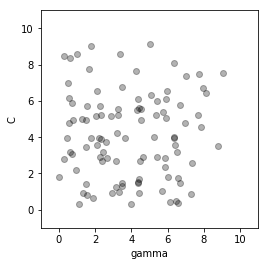

AUC for particle - 1 is 0.571676057888904  At (gamma, c):  [5.91904626 5.0641202 ] .. Time =  0.22499537467956543
AUC for particle - 2 is 0.5683111009712846  At (gamma, c):  [6.41666907 3.54504745] .. Time =  0.23296070098876953
AUC for particle - 3 is 0.5712411147788766  At (gamma, c):  [4.36697934 1.54424562] .. Time =  0.34100985527038574
AUC for particle - 4 is 0.5682107523355269  At (gamma, c):  [5.22452188 4.01970095] .. Time =  0.2310178279876709
AUC for particle - 5 is 0.5626716343895388  At (gamma, c):  [5.41391472 5.98497225] .. Time =  0.23100972175598145
AUC for particle - 6 is 0.5326752546245135  At (gamma, c):  [3.24090977 5.58371636] .. Time =  0.3240013122558594
AUC for particle - 7 is 0.5710538250515507  At (gamma, c):  [6.65864057 5.77817201] .. Time =  0.29500269889831543
AUC for particle - 8 is 0.5321387944221447  At (gamma, c):  [3.24386571 5.23658608] .. Time =  0.20698118209838867
AUC for particle - 9 is 0.5650842397783814  At (gamma, c):  [5.36079836 5.23578809]

AUC for particle - 73 is 0.5914503239595389  At (gamma, c):  [1.56252961 5.7283376 ] .. Time =  0.15196752548217773
AUC for particle - 74 is 0.5537572216558179  At (gamma, c):  [9.04815625 7.55105344] .. Time =  0.34799742698669434
AUC for particle - 75 is 0.5336192091093667  At (gamma, c):  [3.22354561 4.23276128] .. Time =  0.41099095344543457
AUC for particle - 76 is 0.5581470536278003  At (gamma, c):  [3.15885332 1.24312906] .. Time =  0.23900651931762695
AUC for particle - 77 is 0.5602038540847262  At (gamma, c):  [2.12046576 3.54823297] .. Time =  0.176008939743042
AUC for particle - 78 is 0.556710802638573  At (gamma, c):  [7.28336947 0.88042897] .. Time =  0.22897863388061523
AUC for particle - 79 is 0.5472601475503208  At (gamma, c):  [4.40013131 5.61812141] .. Time =  0.2129991054534912
AUC for particle - 80 is 0.5651962729799762  At (gamma, c):  [7.95565347 6.72856108] .. Time =  0.24496912956237793
AUC for particle - 81 is 0.6089004704721119  At (gamma, c):  [0.74661207 3.0

 2 is [0.6057337  3.16395058] with AUC: 0.6162033241203503
23.40172839164734


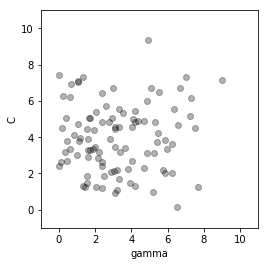

AUC for particle - 1 is 0.5477326793145161  At (gamma, c):  [4.33638929 4.91172592] .. Time =  0.24399566650390625
AUC for particle - 2 is 0.5728849747573769  At (gamma, c):  [5.85804513 3.85198693] .. Time =  0.2307424545288086
AUC for particle - 3 is 0.5562601348755375  At (gamma, c):  [3.20852987 2.21233283] .. Time =  0.1969623565673828
AUC for particle - 4 is 0.5709295131536525  At (gamma, c):  [5.4825545  4.20684553] .. Time =  0.3043036460876465
AUC for particle - 5 is 0.5439566237229165  At (gamma, c):  [4.18948548 5.41888226] .. Time =  0.2839930057525635
AUC for particle - 6 is 0.548279061495672  At (gamma, c):  [2.76359874 4.83173601] .. Time =  0.1999671459197998
AUC for particle - 7 is 0.5661110952676321  At (gamma, c):  [5.32430731 4.8458193 ] .. Time =  0.24196577072143555
AUC for particle - 8 is 0.5433212011892116  At (gamma, c):  [2.9458771  5.08297482] .. Time =  0.21804141998291016
AUC for particle - 9 is 0.5550996396400679  At (gamma, c):  [4.67326645 4.89501281] ..

AUC for particle - 72 is 0.5970979697373706  At (gamma, c):  [1.53360615 1.87882265] .. Time =  0.16999506950378418
AUC for particle - 73 is 0.5889608578927064  At (gamma, c):  [1.65539427 5.06290455] .. Time =  0.25800180435180664
AUC for particle - 74 is 0.5542606085955627  At (gamma, c):  [9.01771018 7.14493776] .. Time =  0.4799938201904297
AUC for particle - 75 is 0.5355869296050458  At (gamma, c):  [3.09506004 4.43800912] .. Time =  0.44599127769470215
AUC for particle - 76 is 0.551471898817205  At (gamma, c):  [2.4680431 1.8586951] .. Time =  0.23098993301391602
AUC for particle - 77 is 0.5700619440424162  At (gamma, c):  [1.90243205 3.34081066] .. Time =  0.1700115203857422
AUC for particle - 78 is 0.5521008057201297  At (gamma, c):  [7.67187192 1.2461336 ] .. Time =  0.2420055866241455
AUC for particle - 79 is 0.5292061862448499  At (gamma, c):  [3.54230714 5.3223056 ] .. Time =  0.22196292877197266
AUC for particle - 80 is 0.5711359140776441  At (gamma, c):  [7.2622957  6.174

 3 is [0.38301443 5.07614768] with AUC: 0.6197242600897216
21.053261280059814


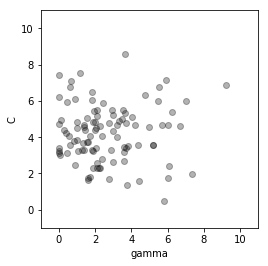

AUC for particle - 1 is 0.5441845915828348  At (gamma, c):  [2.96541119 5.23999689] .. Time =  0.20500850677490234
AUC for particle - 2 is 0.5466795830630039  At (gamma, c):  [4.17067284 4.68906681] .. Time =  0.22496485710144043
AUC for particle - 3 is 0.5624306946811064  At (gamma, c):  [2.04674726 3.37981334] .. Time =  0.19899415969848633
AUC for particle - 4 is 0.5624082167451315  At (gamma, c):  [4.96689672 4.57364982] .. Time =  0.3379998207092285
AUC for particle - 5 is 0.52763671140073  At (gamma, c):  [3.65319502 5.35527671] .. Time =  0.2219991683959961
AUC for particle - 6 is 0.5484341493517243  At (gamma, c):  [2.75419996 4.7580301 ] .. Time =  0.20299649238586426
AUC for particle - 7 is 0.571821104940076  At (gamma, c):  [5.68463799 4.66998067] .. Time =  0.22900176048278809
AUC for particle - 8 is 0.5438083881715753  At (gamma, c):  [2.92887331 5.50096212] .. Time =  0.19599461555480957
AUC for particle - 9 is 0.5298971797815026  At (gamma, c):  [3.48779613 5.02160057] .

AUC for particle - 72 is 0.6117586341019797  At (gamma, c):  [1.24908961 3.27016499] .. Time =  0.23099946975708008
AUC for particle - 73 is 0.5929643664311534  At (gamma, c):  [1.55460427 5.04648453] .. Time =  0.19002342224121094
AUC for particle - 74 is 0.5541553484812837  At (gamma, c):  [9.22199882 6.87611635] .. Time =  0.29596710205078125
AUC for particle - 75 is 0.5730935343553961  At (gamma, c):  [1.87222891 4.83113324] .. Time =  0.15697574615478516
AUC for particle - 76 is 0.5585567858017079  At (gamma, c):  [2.08528868 2.28981765] .. Time =  0.18996620178222656
AUC for particle - 77 is 0.5930352065870849  At (gamma, c):  [1.59131446 3.74115638] .. Time =  0.1479637622833252
AUC for particle - 78 is 0.5555337311630936  At (gamma, c):  [7.31773341 1.97717746] .. Time =  0.2580103874206543
AUC for particle - 79 is 0.5634851970413887  At (gamma, c):  [2.10173689 5.18975802] .. Time =  0.17897534370422363
AUC for particle - 80 is 0.5728028263182369  At (gamma, c):  [7.03863144 6

The best position in iteration number 4 is [0.53770439 4.0747858 ] with AUC: 0.6154326378838181
21.542725563049316


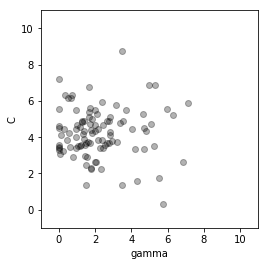

AUC for particle - 1 is 0.5650950133441702  At (gamma, c):  [2.07646171 5.2705591 ] .. Time =  0.16200685501098633
AUC for particle - 2 is 0.5301088090535977  At (gamma, c):  [3.51014109 4.8793562 ] .. Time =  0.19898223876953125
AUC for particle - 3 is 0.5838976780589203  At (gamma, c):  [1.73516192 3.68333643] .. Time =  0.15999627113342285
AUC for particle - 4 is 0.5631877159169137  At (gamma, c):  [5.05491927 4.7514012 ] .. Time =  0.22098064422607422
AUC for particle - 5 is 0.5469552794037148  At (gamma, c):  [2.81938297 5.10557519] .. Time =  0.19299793243408203
AUC for particle - 6 is 0.5669898736403324  At (gamma, c):  [1.99651479 4.35359541] .. Time =  0.1549975872039795
AUC for particle - 7 is 0.5589781233240569  At (gamma, c):  [4.80049468 4.34188986] .. Time =  0.22600698471069336
AUC for particle - 8 is 0.5354963247089355  At (gamma, c):  [3.1223793  5.77844336] .. Time =  0.205979585647583
AUC for particle - 9 is 0.5537895819618822  At (gamma, c):  [2.41907942 4.66566755]

AUC for particle - 73 is 0.5751349864419427  At (gamma, c):  [1.82815932 4.99159848] .. Time =  0.15297698974609375
AUC for particle - 74 is 0.5714366035066373  At (gamma, c):  [7.14398095 5.91392521] .. Time =  0.236983060836792
AUC for particle - 75 is 0.597007226210818  At (gamma, c):  [1.38708379 4.88198738] .. Time =  0.13297748565673828
AUC for particle - 76 is 0.5953219157301191  At (gamma, c):  [1.57309899 2.88151306] .. Time =  0.1459667682647705
AUC for particle - 77 is 0.5931808081600255  At (gamma, c):  [1.58140872 3.75262872] .. Time =  0.1439824104309082
AUC for particle - 78 is 0.56472534536804  At (gamma, c):  [6.87171754 2.62261087] .. Time =  0.23999476432800293
AUC for particle - 79 is 0.5905796059568313  At (gamma, c):  [1.6407034  5.13188443] .. Time =  0.14299941062927246
AUC for particle - 80 is 0.5726385492443057  At (gamma, c):  [5.93908792 5.54854555] .. Time =  0.2300107479095459
AUC for particle - 81 is 0.5341005142001142  At (gamma, c):  [1.00000000e-04 3.2

The best position in iteration number 5 is [0.53928624 4.2554022 ] with AUC: 0.6143833044585927
17.244762897491455


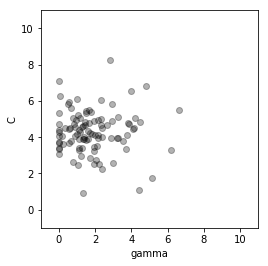

AUC for particle - 1 is 0.5883505472733769  At (gamma, c):  [1.65676808 5.51495825] .. Time =  0.14298534393310547
AUC for particle - 2 is 0.5320502887870152  At (gamma, c):  [3.2495566  5.11014771] .. Time =  0.19795989990234375
AUC for particle - 3 is 0.5994069983815886  At (gamma, c):  [1.00985915 4.18483977] .. Time =  0.1179966926574707
AUC for particle - 4 is 0.5398737195498234  At (gamma, c):  [3.81231513 4.78384514] .. Time =  0.20698213577270508
AUC for particle - 5 is 0.5581580846501245  At (gamma, c):  [2.30953862 4.99560108] .. Time =  0.18700742721557617
AUC for particle - 6 is 0.5853546840057702  At (gamma, c):  [1.69021755 4.218473  ] .. Time =  0.14896297454833984
AUC for particle - 7 is 0.5448990334685574  At (gamma, c):  [3.77610353 4.13450684] .. Time =  0.2170102596282959
AUC for particle - 8 is 0.5440698451854439  At (gamma, c):  [2.92716705 5.82834813] .. Time =  0.19701170921325684
AUC for particle - 9 is 0.5575708064885384  At (gamma, c):  [2.34446345 4.66174838

AUC for particle - 73 is 0.5718903409437486  At (gamma, c):  [1.93890101 4.89876781] .. Time =  0.15599679946899414
AUC for particle - 74 is 0.5703230445780049  At (gamma, c):  [6.61281752 5.48227542] .. Time =  0.23499751091003418
AUC for particle - 75 is 0.5964393959198288  At (gamma, c):  [0.94770351 4.92269183] .. Time =  0.11101198196411133
AUC for particle - 76 is 0.6105170004491627  At (gamma, c):  [1.13387857 3.42787546] .. Time =  0.12398028373718262
AUC for particle - 77 is 0.5977382047278526  At (gamma, c):  [1.51989827 3.84941769] .. Time =  0.14099788665771484
AUC for particle - 78 is 0.5687573919732182  At (gamma, c):  [6.17439763 3.29745623] .. Time =  0.23097634315490723
AUC for particle - 79 is 0.6039591666013123  At (gamma, c):  [1.18747947 5.07674079] .. Time =  0.12296795845031738
AUC for particle - 80 is 0.5450216025837546  At (gamma, c):  [4.18784586 5.0474869 ] .. Time =  0.21899843215942383
AUC for particle - 81 is 0.5343037662326345  At (gamma, c):  [1.00000000

The best position in iteration number 6 is [0.57784114 3.66998864] with AUC: 0.615400911316918
15.680534601211548


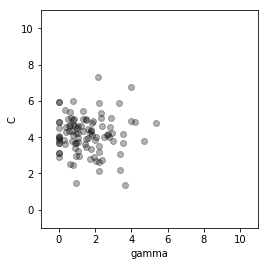

AUC for particle - 1 is 0.5978526738643591  At (gamma, c):  [0.82796477 4.99353063] .. Time =  0.11099743843078613
AUC for particle - 2 is 0.545720002946887  At (gamma, c):  [2.86104703 5.05400821] .. Time =  0.19500994682312012
AUC for particle - 3 is 0.6058177057216348  At (gamma, c):  [0.57273303 4.33207122] .. Time =  0.10896539688110352
AUC for particle - 4 is 0.5429230545593968  At (gamma, c):  [3.96485148 4.91329583] .. Time =  0.21596646308898926
AUC for particle - 5 is 0.5724350595595987  At (gamma, c):  [1.88188164 4.88086496] .. Time =  0.15398240089416504
AUC for particle - 6 is 0.5901521686950281  At (gamma, c):  [1.6268065  3.97306213] .. Time =  0.14200997352600098
AUC for particle - 7 is 0.5426783718290267  At (gamma, c):  [2.99008135 3.7823091 ] .. Time =  0.20102548599243164
AUC for particle - 8 is 0.5589889563028924  At (gamma, c):  [2.34711359 5.3185827 ] .. Time =  0.18596124649047852
AUC for particle - 9 is 0.5539833477112907  At (gamma, c):  [2.37947781 4.6092330

AUC for particle - 72 is 0.598831820677166  At (gamma, c):  [1.491063   3.92279402] .. Time =  0.1406264305114746
AUC for particle - 73 is 0.5808355296356237  At (gamma, c):  [1.76048468 4.42433631] .. Time =  0.1406247615814209
AUC for particle - 74 is 0.5664348171543686  At (gamma, c):  [5.35421652 4.76977748] .. Time =  0.2171001434326172
AUC for particle - 75 is 0.5989741347281933  At (gamma, c):  [0.77163482 4.9554503 ] .. Time =  0.09885001182556152
AUC for particle - 76 is 0.6063462639888018  At (gamma, c):  [0.86700818 3.68268236] .. Time =  0.10657358169555664
AUC for particle - 77 is 0.6038628580527255  At (gamma, c):  [1.43645144 3.63889576] .. Time =  0.13200020790100098
AUC for particle - 78 is 0.5632582392032631  At (gamma, c):  [4.71826436 3.77905984] .. Time =  0.20844054222106934
AUC for particle - 79 is 0.6004816615690273  At (gamma, c):  [0.61481979 4.65233374] .. Time =  0.09374761581420898
AUC for particle - 80 is 0.5461834643192968  At (gamma, c):  [4.21826971 4.8

The best position in iteration number 7 is [0.63085918 2.51471525] with AUC: 0.6212158840384078
14.837660074234009


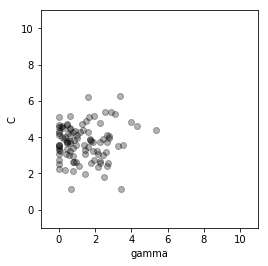

AUC for particle - 1 is 0.6161409998344356  At (gamma, c):  [0.42119989 4.64844266] .. Time =  0.14600014686584473
AUC for particle - 2 is 0.5346759295567233  At (gamma, c):  [3.12087208 5.26214973] .. Time =  0.2389976978302002
AUC for particle - 3 is 0.5938446103256706  At (gamma, c):  [0.2877817  3.92741015] .. Time =  0.15097427368164062
AUC for particle - 4 is 0.5434840919587214  At (gamma, c):  [3.99487466 4.86467354] .. Time =  0.32499170303344727
AUC for particle - 5 is 0.6055635763168506  At (gamma, c):  [1.31833005 4.40757176] .. Time =  0.14599299430847168
AUC for particle - 6 is 0.5794160925385926  At (gamma, c):  [1.79104757 3.77203667] .. Time =  0.1589980125427246
AUC for particle - 7 is 0.5489992466425687  At (gamma, c):  [2.60550977 3.17622496] .. Time =  0.1909775733947754
AUC for particle - 8 is 0.552194302051176  At (gamma, c):  [2.55763187 5.37742277] .. Time =  0.19297266006469727
AUC for particle - 9 is 0.5734288417862254  At (gamma, c):  [1.86251377 3.76104079] 

AUC for particle - 100 is 0.6085754018896518  At (gamma, c):  [0.60487819 3.70668209] .. Time =  0.1081693172454834
The best position in iteration number 8 is [0.68766321 1.15401565] with AUC: 0.6191184450575871
16.1517972946167


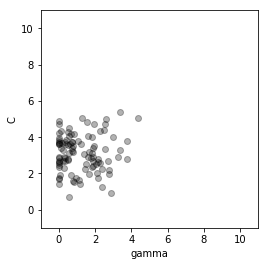

AUC for particle - 1 is 0.5642012826880681  At (gamma, c):  [0.11133974 4.32187822] .. Time =  0.0920107364654541
AUC for particle - 2 is 0.52984063836546  At (gamma, c):  [3.39455585 5.41556976] .. Time =  0.20097732543945312
AUC for particle - 3 is 0.5634301607558606  At (gamma, c):  [0.10247317 3.38131416] .. Time =  0.09496283531188965
AUC for particle - 4 is 0.5491723168474012  At (gamma, c):  [4.35148249 5.03663107] .. Time =  0.21996212005615234
AUC for particle - 5 is 0.6073276684973806  At (gamma, c):  [0.75672747 3.20562977] .. Time =  0.106964111328125
AUC for particle - 6 is 0.5704018658865337  At (gamma, c):  [1.90436761 3.38671193] .. Time =  0.1679975986480713
AUC for particle - 7 is 0.5468875881392546  At (gamma, c):  [2.70096306 2.66449875] .. Time =  0.2810080051422119
AUC for particle - 8 is 0.5511030824280765  At (gamma, c):  [2.51900718 4.73574617] .. Time =  0.28496432304382324
AUC for particle - 9 is 0.568147675484355  At (gamma, c):  [1.95594186 3.48780061] .. T

AUC for particle - 72 is 0.6017476347666136  At (gamma, c):  [1.48563154 2.5109628 ] .. Time =  0.1439969539642334
AUC for particle - 73 is 0.5758857296991561  At (gamma, c):  [1.82620834 3.14168172] .. Time =  0.2380068302154541
AUC for particle - 74 is 0.5561019773454092  At (gamma, c):  [3.74116755 2.81581941] .. Time =  0.2830169200897217
AUC for particle - 75 is 0.6103481287662921  At (gamma, c):  [0.41194527 3.85504511] .. Time =  0.21699762344360352
AUC for particle - 76 is 0.5917464979969881  At (gamma, c):  [0.27817323 2.92150794] .. Time =  0.19699430465698242
AUC for particle - 77 is 0.6019789693658409  At (gamma, c):  [1.45414878 2.26199732] .. Time =  0.31101441383361816
AUC for particle - 78 is 0.5467271927177033  At (gamma, c):  [3.77125095 3.78143337] .. Time =  0.3260319232940674
AUC for particle - 79 is 0.5343037662326345  At (gamma, c):  [1.00000000e-04 3.62897813e+00] .. Time =  0.0839853286743164
AUC for particle - 80 is 0.5452777520321243  At (gamma, c):  [3.37081

The best position in iteration number 9 is [0.67335792 1.92035431] with AUC: 0.6191582319944801
18.110745668411255


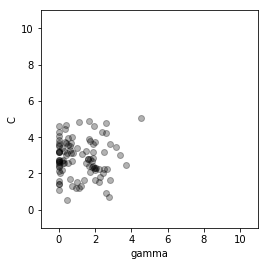

AUC for particle - 1 is 0.5264754834043518  At (gamma, c):  [1.00000000e-04 4.28341185e+00] .. Time =  0.06298398971557617
AUC for particle - 2 is 0.548810649828217  At (gamma, c):  [2.5930195  4.23973269] .. Time =  0.1889965534210205
AUC for particle - 3 is 0.5341005142001142  At (gamma, c):  [1.00000000e-04 3.22580479e+00] .. Time =  0.06599760055541992
AUC for particle - 4 is 0.5499466470841265  At (gamma, c):  [4.5128866  5.05301429] .. Time =  0.34598517417907715
AUC for particle - 5 is 0.6090839577644535  At (gamma, c):  [0.41728905 3.12970834] .. Time =  0.11200380325317383
AUC for particle - 6 is 0.5848198279556605  At (gamma, c):  [1.71314265 2.78134445] .. Time =  0.22701382637023926
AUC for particle - 7 is 0.5507159866249349  At (gamma, c):  [2.49133   2.2582183] .. Time =  0.22099971771240234
AUC for particle - 8 is 0.5537140679796156  At (gamma, c):  [2.38596936 4.29440417] .. Time =  0.1869664192199707
AUC for particle - 9 is 0.5719483082729102  At (gamma, c):  [1.885384

AUC for particle - 72 is 0.587610478560208  At (gamma, c):  [1.67173964 2.38848444] .. Time =  0.1510305404663086
AUC for particle - 73 is 0.5757568826053651  At (gamma, c):  [1.80466901 2.69485203] .. Time =  0.1829831600189209
AUC for particle - 74 is 0.5580392783612139  At (gamma, c):  [3.68835526 2.44412722] .. Time =  0.22299504280090332
AUC for particle - 75 is 0.5932725419040218  At (gamma, c):  [0.31305967 3.76157005] .. Time =  0.09199738502502441
AUC for particle - 76 is 0.5817661359893341  At (gamma, c):  [0.1590049  2.70692699] .. Time =  0.08497953414916992
AUC for particle - 77 is 0.5831736112596436  At (gamma, c):  [1.71842795 2.10178491] .. Time =  0.1559891700744629
AUC for particle - 78 is 0.5369838887661019  At (gamma, c):  [3.16537622 3.46292975] .. Time =  0.20297884941101074
AUC for particle - 79 is 0.5402658258532308  At (gamma, c):  [1.00000000e-04 2.75604075e+00] .. Time =  0.06098461151123047
AUC for particle - 80 is 0.549816433490263  At (gamma, c):  [3.39362

In [27]:
start = time()
while iteration < n_iterations:
    gbest_fitness_value_cadidate = np.array([0])
    gbest_position_cadidate = np.array([float('inf'), float('inf')])
    start1 = time()
    plot(particle_position_vector)
    
    for i in range(n_particles):
        start2 = time()
        fitness_cadidate = fitness_function(particle_position_vector[i])
        stop2 = time()
        print("AUC for particle -", i+1,"is", fitness_cadidate, " At (gamma, c): ", particle_position_vector[i], ".. Time = ", stop2 - start2)
        
        if(pbest_fitness_value[i] < fitness_cadidate):
            pbest_fitness_value[i] = fitness_cadidate
            pbest_position[i] = particle_position_vector[i]

        if(gbest_fitness_value_cadidate < fitness_cadidate):
            gbest_fitness_value_cadidate = fitness_cadidate
            gbest_position_cadidate = particle_position_vector[i]
        
    print("The best position in iteration number", iteration + 1, "is", gbest_position_cadidate, "with AUC:", fitness_function(gbest_position_cadidate))
    
   # if(gbest_fitness_value < gbest_fitness_value_cadidate):
    #    gbest_fitness_value = gbest_fitness_value_cadidate
     #   gbest_position = gbest_position_cadidate
    #print("The best position so far is ", gbest_position, "in iteration number", iteration + 1, "with AUC:", fitness_function(gbest_position))
    
    for i in range(n_particles):
        new_velocity = khi*(velocity_vector[i] + (c1*random.random()) * (pbest_position[i] - particle_position_vector[i]) + (c2*random.random()) * (gbest_position_cadidate-particle_position_vector[i]))
        new_velocity = eval_velocity(new_velocity)
        particle_position_vector[i] = new_velocity + particle_position_vector[i]
        particle_position_vector[i] = eval_position(particle_position_vector[i])
    
    iteration = iteration + 1
    stop1 = time()
    sec = stop1-start1
    print(sec)
stop = time()
print(stop - start)